# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Raport z drugiego kamienia milowego projektu  

#### Klasyfikacja tweetów Elona Muska


Na podstawie niżej wymienionych zmiennych będzie wykonywana klasyfikacja binarna tweetów Elona Muska:

* is Elon Musk - zmienna określa czy wpis należał do Elona Muska, jest kluczowa będzie wykorzystywana jako etykieta w trakcie klasyfikacji 
* source - źródło wpisu, czy jest to aplikacja czy strona *www*, z analizy danych zostało zauważone iż Elon dodaje wpisy tylko z aplikacji 
* lang	- język wpisu, w przypadku wpisów Elona duża część ma kategorie `und` (niezdefiniowany) 
* has_text - informacja czy tweet zawiera czysty tekst, bez linków, hashtagów czy emoji 
* has_link - informacja czy tweet zawiera link 
* has_hashtag - informacja czy tweet zawiera jakiś hashtag 
* has_at - informacja czy w wpisie byli oznaczeni inni użytkownicy 
* has_emoji	- informacja czy tweet zawiera emocji
* sentiment	- sentyment wpisu, obliczane tylko dla anglojęzycznych wpisów, bez emoji, linków, itd. Gdy tekst po oczyszczeniu jest pusty sentyment przyjmuje wartość dwa 
* retweet count	- liczba retweetów, Elon Musk miał średnio więcej retweetów
* reply count - liczba odpowiedzi, Elon Musk miał średnio więcej odpowiedzi
* like count - liczba polubień, Elon Musk miał średnio więcej polubień
* quote count - liczba cytowań, Elon Musk miał średnio więcej cytowań	

Dodatkowo zostaną wzięte pod uwagę konteksty wypowiedzi ich dziedzina oraz podmiot(tylko trzy pierwsze z 6 możliwych):

* context annotations domain 0
* context annotations entity 0 	
* context annotations domain 1 
* context annotations entity 1 	
* context annotations domain 2
* context annotations entity 2

Informacje te będą przydatne ponieważ będą świadczyć o czym najczęściej pisze Elon Musk.

W zadaniu klasyfikacji zmienna **is Elon Musk** będzie etykietą reszta natomiast będzie zestawem cech, na podstawie których 
przygotowane modele będą dokonywać klasyfikacji. 

#### Dobroć modelu


W przypadku klasyfikacji tweetów Elona Muska zmagamy się z problemem niezbilansowanego zbioru danych, 
wpisy Elona Muska stanowią między innymi około 12%. W takim przypadku poleganie na dokładności klasyfikacji może dawać
fałszywe poczucie dobrego działania modelu(model może osiągnąć wysoką dokładność, klasyfikując wszystkie próbki jako klasę dominującą).
 Do analizy działania modelu zostały wykorzystane następujące wskaźniki:

* Tablica pomyłek 
* Precyzja 
* Zwrot 
* Dokładność 
* Krzywe uczenia 

#### Wczytanie Danych

In [41]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

users = ['elonmusk', 'joebiden', 'BarackObama', 'twitter', 'theellenshow', 'youtube', 'cristiano', 'justinbieber', 'cnnbrk', 'billgates', 'KimKardashian']


def get_data(path="basic"):
    df_from_each_file = (pd.read_csv(f'user_data/{path}_{user}_tweets.csv') for user in users)
    return pd.concat(df_from_each_file, ignore_index=True)

data_frame = pd.read_csv('main_df.csv')
data_annotations_frame = get_data('annotations')
old_elon_basic = pd.read_csv('old_elon_basic.csv')
old_elon_annotations = pd.read_csv('old_elon_annotations.csv')

used_annotations = 3
max_annotations = 6
    

columns_to_be_dropped = [
    'created at',
    'possibly sensitive',
    'annotations',
    'retweet count',
    'reply count',
    'like count',
    'quote count']

for i in range(max_annotations - used_annotations):
    domain = f'context annotations domain {used_annotations + i}'
    columns_to_be_dropped.extend([domain])

for i in range(max_annotations - 0):
    context = f'context annotations entity {i}'
    columns_to_be_dropped.extend([context])

old_elon_data = pd.concat([old_elon_basic, old_elon_annotations], axis=1)
old_elon_data = old_elon_data.loc[:,~old_elon_data.columns.duplicated()].copy()
old_elon_data.drop(columns_to_be_dropped, axis=1, inplace=True)

latest_data = pd.concat([data_frame, data_annotations_frame], axis=1)
latest_data = latest_data.loc[:,~latest_data.columns.duplicated()].copy()
latest_data.drop(columns_to_be_dropped, axis=1, inplace=True)
latest_data = pd.concat([latest_data, old_elon_data], axis=0)

#### Wygląd ramki danych

In [42]:
latest_data.head()

,is Elon Musk,source,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,context annotations domain 0,context annotations domain 1,context annotations domain 2
0,1,Twitter for iPhone,und,0,1,0,0,1,2.0,Business Taxonomy,Business Taxonomy,Person
1,1,Twitter for iPhone,en,1,1,0,0,0,0.0,Person,Politician,Business Taxonomy
2,1,Twitter for iPhone,en,1,0,0,0,0,0.8,Business Taxonomy,Business Taxonomy,Person
3,1,Twitter for iPhone,en,1,0,0,0,0,0.0,Business Taxonomy,Business Taxonomy,Person
4,1,Twitter for iPhone,en,1,0,0,0,0,0.0,Business Taxonomy,Business Taxonomy,Person


#### Kodowanie wartości 

Wartości inne niż liczbowe, przed przekazaniem do modelu muszą być zakodowane do postaci liczbowych.
W projekcie wykorzystano kodowanie udostępnione przez klasę **LabelEncoder**.  

In [43]:
from sklearn.preprocessing import LabelEncoder 


for i in range(used_annotations):
    col_1, col_2 = f'context annotations domain {i}', f'context annotations entity {i}'
    latest_data = latest_data[latest_data[col_1].notnull()]
    # latest_data = latest_data[latest_data[col_2].notnull()]

for col in ['source', 'lang']:
    le = LabelEncoder()
    latest_data[col]= le.fit_transform(latest_data[col])

for i in range(used_annotations):
    col_1, col_2 = f'context annotations domain {i}', f'context annotations entity {i}'
    le = LabelEncoder()
    latest_data[col_1]= le.fit_transform(latest_data[col_1])
    # le = LabelEncoder()
    # latest_data[col_2]= le.fit_transform(latest_data[col_2])

#### Przykład zakodowanych danych

In [44]:
latest_data.head()

,is Elon Musk,source,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,context annotations domain 0,context annotations domain 1,context annotations domain 2
0,1,14,25,0,1,0,0,1,2.0,2,5,30
1,1,14,6,1,1,0,0,0,0.0,16,30,6
2,1,14,6,1,0,0,0,0,0.8,2,5,30
3,1,14,6,1,0,0,0,0,0.0,2,5,30
4,1,14,6,1,0,0,0,0,0.0,2,5,30


#### Podział danych na etykiety i zbiór cech

Etykiety są wartościami pobranymi z pierwszej kolumny, pozostałe kolumny to wartości wektora cech. 

In [45]:
y = latest_data.iloc[:, 0]
x = latest_data.iloc[:, 1:]

#### Podział na zbiór testowych oraz treningowy

Przygotowane dane są podzielone w następujący sposób:
* 80% - zbiór treningowy
* 20% - zbiór testowy

Dodatkowo wykorzystany zostaje parametr **stratify**, który pozwoli zachować proporcje między klasami w zbiorze treningowym oraz  testowym.

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

#### Wielowarstwowy Perceptron

Jako pierwszy model zastosowano wielowarstwowy perceptron. Obserwując wyniki klasyfikacji można zauważyć takie cechy jak:
* Największy problem widać w macierzy pomyłek, gdzie widać przypadki FP oraz FN, czyli przypisano 52 próbek z klasy pierwszej(nie Elon)
do klasy drugiej(Elon) oraz 8 z klasy drugiej do klasy pierwszej.
* Współczynniki czułości w obu przypadkach przewyższa 0.90, podniesienie wartości precyzji polepszyłoby działanie modelu  
* Wysoką dokładność 


In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mlp_classifier = MLPClassifier(hidden_layer_sizes = (100, 50), random_state = 42,activation= 'tanh', max_iter=1000)
mlp_classifier.fit(x_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(x_test)

print(f'MLPClassifier accuracy:  {100*accuracy_score(labels_predicted_mlp, y_test)}[%]')
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))

MLPClassifier accuracy:  98.6235375086029[%]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1263
           1       0.97      0.93      0.95       190

    accuracy                           0.99      1453
   macro avg       0.98      0.96      0.97      1453
weighted avg       0.99      0.99      0.99      1453

[[1257    6]
 [  14  176]]


In [48]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    

    plt.title('Krzywa uczenia oraz krzywa walidacji')
    plt.xlabel("Liczba próbek")
    plt.ylabel("Dokładność")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
   
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Dokładność uczenia"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Dokładność walidacji krzyżowej"
    )
    plt.legend(loc="best")
    plt.show()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji nie poprawia dokładności
* Krzywa uczenia nie ma symptomów przeuczenia, dokładność zbioru treningowego jest zbliżona do zbioru testowego  

/home/wiktor/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


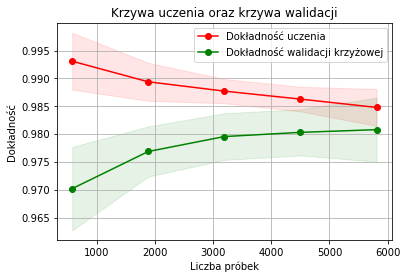

In [49]:
plot_learning_curve(mlp_classifier, x, y, cv=cv, n_jobs=4)

#### Drzewo Decyzyjne

Jako drugi model wykorzystano drzewo decyzyjne.Obserwując wyniki klasyfikacji można zauważyć:
* Klasyfikator prawie się nie mylił na zbiorze testowym blednie zaklasyfikował tylko 15 próbek.
* Obie wartości precyzji i zwrotu osiągają wartości bliskie 1
* Dokładność na poziomie 99%


In [50]:
from sklearn import tree

tree_cls = tree.DecisionTreeClassifier()
tree_cls = tree_cls.fit(x_train, y_train)

labels_predicted_tree = tree_cls.predict(x_test)
print(f'DecisionTreeClassifier accuracy:  {100*accuracy_score(labels_predicted_tree, y_test)}[%]')
print(classification_report(y_test, labels_predicted_tree))
print(confusion_matrix(y_test, labels_predicted_tree))

DecisionTreeClassifier accuracy:  98.0041293874742[%]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1263
           1       0.91      0.94      0.92       190

    accuracy                           0.98      1453
   macro avg       0.95      0.96      0.96      1453
weighted avg       0.98      0.98      0.98      1453

[[1246   17]
 [  12  178]]


#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji poprawia dokładność zbioru testowego 
* Krzywa uczenia może wyglądać jakby model był przeuczony jednak różnica między  zbiorem testowym a treningowym w finalnej fazie wynosi mniej niż 0.15%

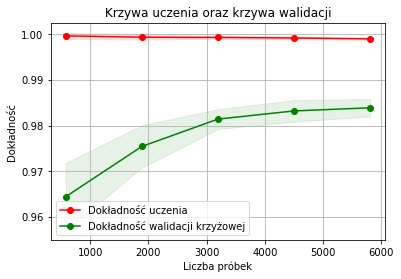

In [51]:
plot_learning_curve(tree_cls, x, y, cv=cv, n_jobs=4)

#### Reprezentacja drzewa edycyjnego

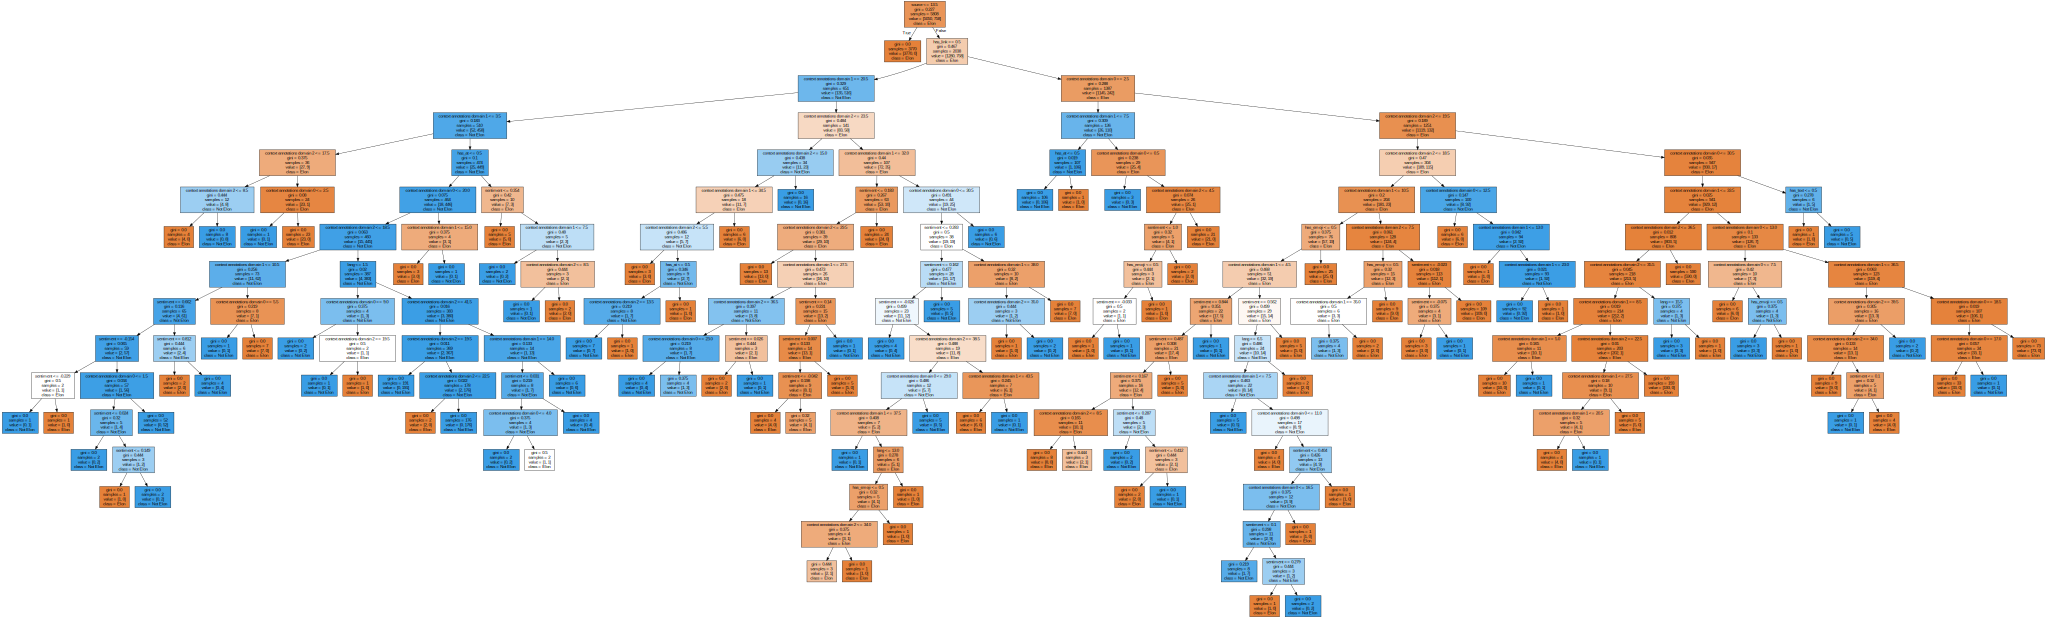

In [52]:
import graphviz
dot_data = tree.export_graphviz(tree_cls, filled=True, feature_names = x.columns.values.tolist(), class_names = ['Elon', 'Not Elon'])
graph = graphviz.Source(dot_data, format="png") 
graph

### Podsumowanie


Wybrane zmienne pozwoliły osiągnąć bardzo skuteczne modele. Analiza macierzy pomyłek uwydatniła problem niezbalansowanego 
zbioru danych. Klasyfikator oparty o drzewa decyzyjne dał dużo lepszy rezultat. Dalsza praca nad doborem hiperparametrów
oraz wybranie lepszego zbioru cech może usprawnić działanie klasyfikatorów   